In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
plt.style.use('../paper.mplstyle')

from astropy import units as u
from scipy.constants import G
import time

# (1) Preparation of initial conditions

## (1-1) Read in mass profiles

Having a pre-calculated list of $M_\text{in}(r)$ helps running the simulation much faster.

In [2]:
# read in mass profiles
R_list = np.load('data/R_list.npy')
bulge_mass_list = np.load('data/bulge_mass_list.npy')
disk_mass_list = np.load('data/disk_mass_list.npy')
halo_mass_list = np.load('data/halo_mass_list.npy')
total_mass_list = bulge_mass_list + disk_mass_list + halo_mass_list

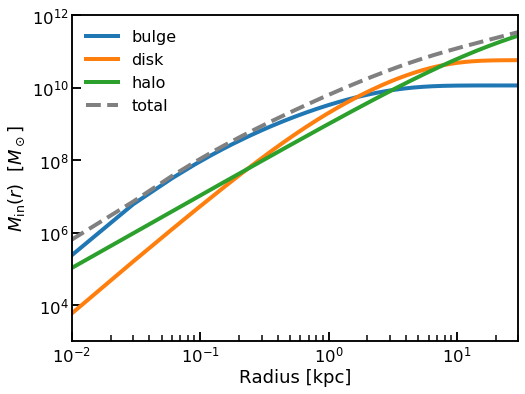

In [3]:
plt.figure(figsize=(8,6))
plt.plot(R_list,bulge_mass_list,label='bulge')
plt.plot(R_list,disk_mass_list,label='disk')
plt.plot(R_list,halo_mass_list,label='halo')
plt.plot(R_list,total_mass_list,label='total',linestyle='--',color='gray')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,30)
plt.ylim(1e3,1e12)
plt.yticks([1e4,1e6,1e8,1e10,1e12])
plt.xlabel('Radius [kpc]')
plt.ylabel(r'$M_\mathrm{in}(r)\ \  [M_\odot]$')
plt.savefig('img/Mass_profile.pdf',bbox_to_inches='tight')

## (1-2) Initial velocity calculation

Consider stars at $(x,y) = (r\cos\theta,r\sin\theta)$.
Assuming circular orbit (clockwise), the orbital velocity of an object at radius $r$ is 
$$\vec{v}(r) = \sqrt{\frac{GM_\text{in}(r)}{r}}\hat{v} = \sqrt{\frac{GM_\text{in}(r)}{r}}\left(\cos(\theta-90^o),\sin(\theta-90^o)\right)$$

In [4]:
# rescaling units: don't forget to change SI units to simulation units!
Msun_to_kg = ((1*u.solMass)/(1*u.kg)).to(u.kg/u.kg).value
kpc_to_meter = ((1*u.kpc)/(1*u.meter)).to(u.meter/u.meter).value
sec_to_Myr = ((1*u.s)/(1*u.Myr)).to(u.s/u.s).value

In [26]:
def get_M_arr(r_list,src='full'):
    '''
    global:
        R_list: an array of radii at which M_in(r) are calculated
    input: 
        r_list: an array of radii
        src:    the source of the mass. 'full' = 'bulge'+'disk'+'halo'
    output: 
        mass_list: an array of enclosed mass at each r. unit=[Msun]
    '''
    global R_list # we don't really need to declare this
    idx = np.argmin(abs(R_list[:,np.newaxis]-r_list[np.newaxis,:]),axis=0)
    if src=='full':
        return total_mass_list[idx]
    elif src=='bulge':
        return bulge_mass_list[idx]
    elif src=='disk':
        return disk_mass_list[idx]
    elif src=='halo':
        return halo_mass_list[idx]
    else:
        print('Error: select mass sources from the following: [\'full\',\'bulge\',\'disk\',\'halo\']')
        assert False
    
def calc_v(r_list,src='full'):
    v_list = []
    v_list.append(np.sqrt(G*get_M_arr(r_list,src)*Msun_to_kg/(r_list*kpc_to_meter)))
    return np.array(v_list)[0] #m/s

def get_v_init(r,theta):
    '''
    Calculates the initial velocity from the initial coordinates.
    input: polar coordinates
        r: an array of radii. unit=[kpc]
        theta: an array of the initial angle. unit=[radian]
    output:
        vx,vy: arrays of xy-velocity
    '''
    v = calc_v(r)
    vx = v*np.cos(theta-np.pi/2)/sec_to_Myr/kpc_to_meter
    vy = v*np.sin(theta-np.pi/2)/sec_to_Myr/kpc_to_meter
    return vx,vy #[kpc/Myr]

## (1-3) theoretical rotation curve

In [27]:
x_th = np.linspace(1e-1,30,1000)
v_bulge = calc_v(x_th,src='bulge')
v_disk  = calc_v(x_th,src='disk')
v_halo  = calc_v(x_th,src='halo')
v_full  = calc_v(x_th,src='full')

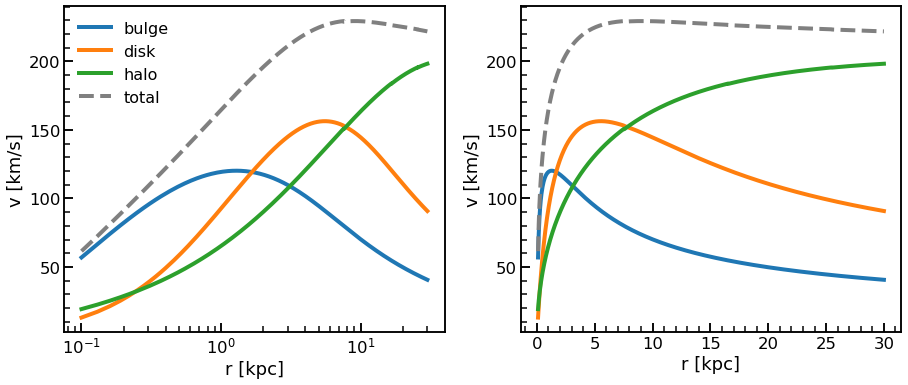

In [28]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.plot(x_th,v_bulge/1000,label='bulge')
ax1.plot(x_th,v_disk/1000,label='disk')
ax1.plot(x_th,v_halo/1000,label='halo')
ax1.plot(x_th,v_full/1000,label='total',c='gray',linestyle='--')
ax1.set_xscale('log')
ax1.set_ylabel('v [km/s]')
ax1.set_xlabel('r [kpc]')
ax1.legend();

ax2.plot(x_th,v_bulge/1000,label='bulge')
ax2.plot(x_th,v_disk/1000,label='disk')
ax2.plot(x_th,v_halo/1000,label='halo')
ax2.plot(x_th,v_full/1000,label='total',c='gray',linestyle='--')
ax2.set_ylabel('v [km/s]')
ax2.set_xlabel('r [kpc]')

plt.savefig('img/rotation_curve.pdf',bbox_to_inches='tight')

## (1-4) create/save/load initial conditions

### Create the initial condition

In [16]:
def initialize(N_objects,r_min,r_max,M_min,M_max):
    # initial polar coordinates (easier to calculate velocities)
    theta_init = np.random.uniform(0,2*np.pi,N_objects)
    r_init = np.random.uniform(r_min,r_max,N_objects)
    M_list = np.random.uniform(M_min,M_max,N_objects) # it's not uniform in the real life

    # velocities
    vx_init, vy_init = get_v_init(r_init,theta_init)

    # xy-coordinates
    x_init = r_init*np.cos(theta_init)
    y_init = r_init*np.sin(theta_init)
    return x_init,y_init,vx_init,vy_init,M_list

In [570]:
# Initial positions and masses of objects
N_objects = 1000
r_min = 0.1 #[kpc]
r_max = 30  #[kpc]
M_min = 0.1 #[Msun]
M_max = 10  #[Msun]

x_init,y_init,vx_init,vy_init,M_list = initialize(N_objects,r_min,r_max,M_min,M_max)

### save the initial condition

In [475]:
np.save('data/initial_conditions',[x_init,y_init,vx_init,vy_init])
np.save('data/stellar_mass_list',M_list)

### load the initial condition

In [500]:
x_init,y_init,vx_init,vy_init = np.load('data/initial_conditions.npy')
M_list = np.load('data/stellar_mass_list')

### plot the initial rotation curve and compare it with theoretical line

In [326]:
v_list = np.sqrt(vx_init**2+vy_init**2)

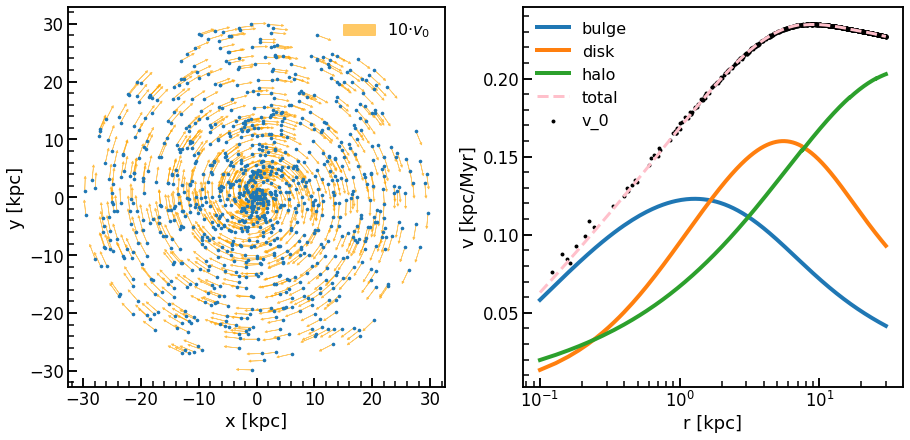

In [502]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(x_init,y_init,s=2,zorder=1)
for x,y,vx,vy in zip(x_init,y_init,vx_init,vy_init):
    arr = ax1.arrow(x,y,vx*10,vy*10,lw=0.7,color='orange',alpha=0.6,zorder=0,head_width=0.4,head_length=0.4)
ax1.legend([arr],[r'10$\cdot v_0$'],frameon=False,loc=1)
ax1.set_aspect('equal')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')


ax2.plot(x_th,v_bulge/kpc_to_meter/sec_to_Myr,label='bulge')
ax2.plot(x_th,v_disk/kpc_to_meter/sec_to_Myr,label='disk')
ax2.plot(x_th,v_halo/kpc_to_meter/sec_to_Myr,label='halo')
ax2.plot(x_th,v_full/kpc_to_meter/sec_to_Myr,label='total',c='pink',linestyle='--',lw=3)
ax2.scatter(r_init,v_list,s=3,label=r'v_0',zorder=0,c='k')
ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('r [kpc]')
ax2.set_ylabel('v [kpc/Myr]')
plt.savefig('img/initial_condition.pdf',bbox_to_inches='tight')

# (2) N-body simulation code: force calculation

As we all know, gravitational force between two objects is
$$
\vec{F}_{ij} = \frac{GM_iM_j}{r_{ij}^2}\hat{r} = \frac{GM_iM_j}{r_{ij}^2}\frac{\vec{r_{ij}}}{|r_{ij}|}
= \frac{GM_iM_j}{r_{ij}^3}\vec{r}.
$$
When calculating the force from the galaxy's global gravitationa potential, $M_j=M_\text{in}(|r_i|)$.

In [17]:
def calc_F(x_list,y_list,M_list,):
    '''
    Calculates the gravitational interaction between each particle and the global gravitational potential
    input:
        x_list: an array of x-coordinates of objects [kpc]
        y_list: an array of y-coordinates of objects [kpc]
        M_list: an array of stellar masses [Msun]
    output:
        Fx,Fy: arrays of forces decomposed to xy-directions in SI units [Newtons]
    '''
    #### N-body forces (small forces, particle interactions: log10(M)~1 for most of the objects):
    # vec{F} = GMM/r^2 * \hat{r} = GMM/R^3 * \vec{r}
    # some operations are faster to use np.XXX() functions rather than regular operators (e.g. +,*,**)
    # because some parts of this is 2-D matrix operation
    
    # distance
    Dx = -(x_list[:,np.newaxis]-x_list[np.newaxis,:])*kpc_to_meter
    Dy = -(y_list[:,np.newaxis]-y_list[np.newaxis,:])*kpc_to_meter
    D  = np.sqrt(np.add(np.power(Dx,2),np.power(Dy,2)))
    D3 = np.power(D,3) # |r|^3
    
    # Mass
    MM = (M_list[:,np.newaxis]*M_list[np.newaxis,:])*Msun_to_kg**2
    GMM = np.multiply(G,MM)
    
    # Force
    Fx_N  = np.nansum(np.multiply(np.divide(GMM,D3),Dx),axis=1)
    Fy_N  = np.nansum(np.multiply(np.divide(GMM,D3),Dy),axis=1)
    
    #### Galaxy global force (large centripital force, fixed center of rotation, log10(M_gal)~11-12)
    # this part does not take much time to compute (because this is 1-D operation)
    R = np.sqrt(x_list**2+y_list**2)
    M_gal = get_M_arr(R)*Msun_to_kg # do not correct R to SI units: get_M_arr() expects [kpc]
    Fx_gal = G*M_gal*(M_list*Msun_to_kg)/(R*kpc_to_meter)**3 * (-x_list*kpc_to_meter)
    Fy_gal = G*M_gal*(M_list*Msun_to_kg)/(R*kpc_to_meter)**3 * (-y_list*kpc_to_meter)

    #### combine two forces
    Fx = Fx_N + Fx_gal
    Fy = Fy_N + Fy_gal
    return Fx,Fy # [Newton]

In [563]:
start = time.time()
for _ in range(100):
    Fx,Fy = calc_F(x_init,y_init,M_list)
print(f'average calc_F() execution time: {(time.time()-start)/100:.4f} sec')

average calc_F() execution time: 0.0936 sec


### test: let's see if forces correctly point towards the center

note:<br>
'Divide by zero' warnings are expected since we do not exclude the self-interaction term.<br>
This term diverges since $F_{ii} = GM_iM_i/r_{ii}^2 = GM_iM_i/0 = \infty$.<br>
We get rid of this term by taking ```np.nansum()``` which treats ```NaN``` as $0$ to return finite values. The regular ```np.sum()``` would return ```NaN```.

In [403]:
Fx,Fy = calc_F(x_init,y_init,M_list)

/home/sterlingym/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/sterlingym/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/home/sterlingym/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/sterlingym/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Text(0, 0.5, 'y [kpc]')

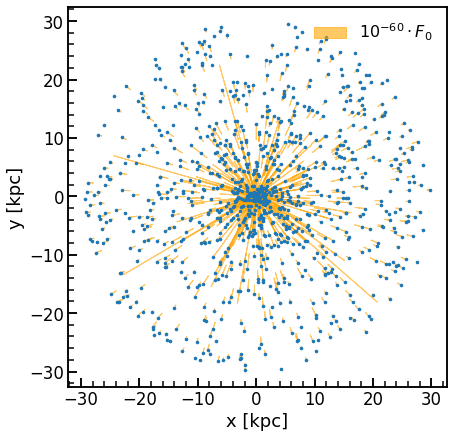

In [525]:
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(x_init,y_init,s=2,zorder=1)
for x,y,fx,fy in zip(x_init,y_init,Fx,Fy):
    arr = ax1.arrow(x,y,fx*1e-21,fy*1e-21,lw=1,color='orange',alpha=0.6,zorder=0)
ax1.legend([arr],[r'$10^{-60}\cdot F_0$'],frameon=False,loc=1)
ax1.set_aspect('equal')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

# (3) N-body sim prep2: differential equation (RK4)

The motion of objects is described by four parameters, $x_i(t)$, $y_i(t)$, $v_{x,i}(t)$, and $v_{y,i}(t)$.
Starting from t=0, the simplest way to calculate the time evolution is to do:<br>
$x_i(t+\Delta t) = x_i(t) + \frac{\mathrm dx_i}{\mathrm dt}\Delta t$<br>
$y_i(t+\Delta t) = x_i(t) + \frac{\mathrm dy_i}{\mathrm dt}\Delta t$<br>
$v_{x,i}(t+\Delta t) = v_{x,i}(t) + \frac{\mathrm dv_{x,i}}{\mathrm dt}\Delta t$<br>
$v_{y,i}(t+\Delta t) = v_{y,i}(t) + \frac{\mathrm dv_{y,i}}{\mathrm dt}\Delta t$<br>.

The above method is know as Euler's method, but this is not very accurate unless the time step $\Delta t$ is taken extremely small. Runge-Kutta method (RK4) provides an improved accuracy, and is a standard method to perform simulations.


In [18]:
# rescaling factor for the acceleration
meter_per_sec2_to_rescaled_unit = (1/kpc_to_meter)/(sec_to_Myr**2)

In [19]:
def calc_deriv(val,M_list):
    '''
    Calculates the derivative of zeroth and first derivative terms (i.e. position and velocity).
    Note that returned values are in rescaled units (not SI)!
    This function can easily be expanded to 3D.
    inputs:
        val: a list of values whose time derivatives are to be calculated. val=[x,y,vx,vy]
        M_list: a list of masses. This could've been included in values but 
                I found it more appropriate to distinguish between ODE variabels and parameters.
    output:
        derivs: time derivatives of values. d/dt(val)=[vx,vy,ax,ay].
    '''
    x_list,y_list,vx_list,vy_list = val
    
    # time derivatives of positions (= velocities)
    dxdt = vx_list
    dydt = vy_list
    
    # time derivatives of velocities (= accelerations)
    Fx,Fy = calc_F(x_list,y_list,M_list)
    dvxdt = Fx/(M_list*Msun_to_kg)*meter_per_sec2_to_rescaled_unit
    dvydt = Fy/(M_list*Msun_to_kg)*meter_per_sec2_to_rescaled_unit
    
    return np.array([dxdt,dydt,dvxdt,dvydt]) # in rescaled units (e.g. r~kpc, M~Msun, t~Myr)

In [20]:
def get_next_RK4(val_old,dt,M_list):
    '''
    Calculates the values at the next step using RK4 method.
    inputs:
        val_old: values calculated by the previous time step. 
                 val_old=[x_old,y_old,vx_old,vy_old] in rescaled units.
        dt:      size of time step
        M_list:  a list of masses of objects
    output:
        val_new: calculated values with time eolution size dt.
    '''
    val_old = np.array(val_old)
    k1 = val_old + 0.5*dt*calc_deriv(val_old,M_list)
    k2 = val_old + 0.5*dt*calc_deriv(k1,M_list)
    k3 = val_old +     dt*calc_deriv(k2,M_list)
    k4 =               dt*calc_deriv(k3,M_list)    
    return (k1 + 2*k2 + k3)/3 + k4/6 - val_old/3

# (4) Run simulation: Galaxy only

In [21]:
# 'divide by zero' warnings are expected. Run this only after checking all other parts are working
from warnings import filterwarnings
filterwarnings(action='ignore')

In [23]:
def run_simulation(val_init,M_list,dt,t_max,save_interval):
    t = 0
    val_old = val_init
    data = []
    t_list = []
    while t<=tmax:
        print(f'\rsimulating... t={t}/{tmax}',end='')
        val_new = get_next_RK4(val_old,dt,M_list)
        t += dt
        if t%save_interval==0:
            data.append(val_new)
            t_list.append(t)
        val_old = val_new
    return data,t_list

In [515]:
# initial conditions & simulation parameters 
val_init = [x_init,y_init,vx_init,vy_init]
dt   = 0.5  # [Myr]
tmax = 300  # [Myr]
save_interval = 1 # this needs to be an integer multiple of dt

data,t_list = run_simulation(val_init,M_list,dt,tmax,save_interval)

simulating... t=300.0/300

In [516]:
np.save('data/data1',[data,t_list])

# (5) Create an animation

In [38]:
from matplotlib.animation import FuncAnimation

# animation export takes time! Be patient :)
def save_animation(data_ani,t_list_ani,filename,fps=60,distinguish_extra_obj=False,alpha=1.0):
    '''
    Creates an animation and exports to .mp4 files.
    inputs:
        data_ani:   an array (or a list) of values at each time t. For the format of values, see get_next_RK4().
        t_list_ani: an array (or a list) of t at which values in data are evaluated.
        filename:   file name of exported mp4 files. make sure to include '.mp4' at the end.
        fps:        an integer value to specify the number of frames per second.
        distinguish_extra_obj: this is specific to my simulation and not very universal. 
                               When True, this function plots a large pink object for 
                               the first element of array. 
    '''
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(17,8))

    x1,y1 = [],[]
    x2,y2 = [],[]
    x3,y3 = [],[]

    sc1, = ax1.plot(x1, y1, marker='o', ls='', ms=15, zorder=1, markeredgecolor='none',color='pink')
    sc2, = ax1.plot(x2, y2, marker='o', ls='', ms=2, zorder=1, markeredgecolor='none',color='lightgreen',alpha=alpha)
    sc3, = ax2.plot(x3, y3, marker='o', ls='', ms=2, markeredgecolor='none',alpha=alpha)
    text = ax1.text(10,35,'',fontdict={'color':'lightblue','size':20})
    
    def init():
        ax1.set_aspect('equal')
        ax1.set_xlim(-40,40)
        ax1.set_ylim(-40,40)
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax2.set_xlabel('r [kpc]')
        ax2.set_ylabel('v [kpc/Myr]')
        ax2.set_ylim(0,0.5)
        ax2.set_xlim(0,40)
        fig.patch.set_facecolor('black')
        for ax in [ax1,ax2]:
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('lightblue')
            ax.spines['top'].set_color('lightblue') 
            ax.spines['right'].set_color('lightblue')
            ax.spines['left'].set_color('lightblue')
            ax.xaxis.label.set_color('lightblue')
            ax.yaxis.label.set_color('lightblue')
            ax.tick_params(axis='x', colors='lightblue')
            ax.tick_params(axis='y', colors='lightblue')
        return sc1,sc2,sc3,text,

    def update(frame):
        x,y,vx,vy = data_ani[frame]
        
        if distinguish_extra_obj:
            sc1.set_data(x[0], y[0])
            sc2.set_data(x[1:],y[1:])
            sc3.set_data(np.sqrt(x**2+y**2)[1:],np.sqrt(vx**2+vy**2)[1:])
        else:
            sc2.set_data(x,y)
            sc3.set_data(np.sqrt(x**2+y**2),np.sqrt(vx**2+vy**2))
        text.set_text(f't={int(t_list_ani[frame]):} Myr')
        return sc1,sc2,sc3,text,

    ani = FuncAnimation(fig, update, frames=len(data_ani), 
                        init_func=init, blit=True)
    ani.save(filename, fps=fps, dpi=200, savefig_kwargs={'facecolor':'black'})
    print('Done.')

Done.


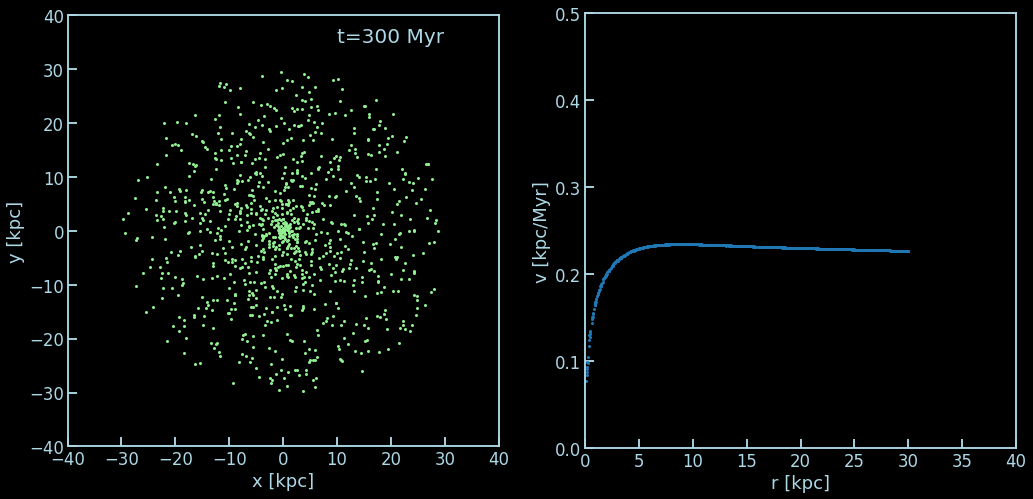

In [513]:
save_animation(data,t_list,'ani/animation01.mp4')

# (6) Run simulation 2: with an extragalactic object

In [573]:
# Initial positions and masses of objects
N_objects = 1000
r_min = 0.1 #[kpc]
r_max = 30  #[kpc]
M_min = 0.1 #[Msun]
M_max = 100 #[Msun]

x_init,y_init,vx_init,vy_init,M_list = initialize(N_objects,r_min,r_max,M_min,M_max)

x_init2 = np.concatenate([[-10],x_init])
y_init2 = np.concatenate([[-50],y_init])
vx_init2 = np.concatenate([[0],vx_init])
vy_init2 = np.concatenate([[0.17],vy_init])
M_list2 = np.concatenate([[1e10],M_list])

In [ ]:
val_init2 = [x_init2,y_init2,vx_init2,vy_init2]
dt = 0.5
tmax = 3600
save_interval = 1

data2,t_list2 = run_simulation(val_init2,M_list2,dt,tmax,save_interval)

In [575]:
np.save('data/data2',[data2,t_list2])

Done.


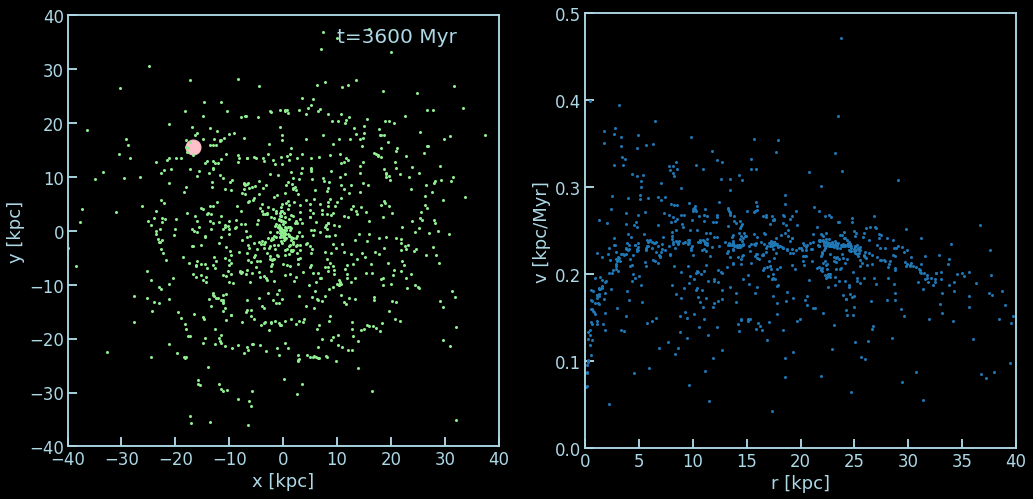

In [576]:
save_animation(data2,t_list2,'ani/animation02.mp4',distinguish_extra_obj=True)

# (7) Run simulations 3: More objects!

This will take a very long time to calculate. Start it before you go to bed tonight :)

In [30]:
# Initial positions and masses of objects
N_objects = 3000
r_min = 0.1 #[kpc]
r_max = 30  #[kpc]
M_min = 0.1 #[Msun]
M_max = 100 #[Msun]

x_init,y_init,vx_init,vy_init,M_list = initialize(N_objects,r_min,r_max,M_min,M_max)

x_init3 = np.concatenate([[-10],x_init])
y_init3 = np.concatenate([[-50],y_init])
vx_init3 = np.concatenate([[0],vx_init])
vy_init3 = np.concatenate([[0.17],vy_init])
M_list3 = np.concatenate([[1e10],M_list])

In [31]:
val_init3 = [x_init3,y_init3,vx_init3,vy_init3]
dt = 0.5
tmax = 3400
save_interval = 1

data3,t_list3 = run_simulation(val_init3,M_list3,dt,tmax,save_interval)

simulating... t=3400.0/3400

In [32]:
np.save('data/data3',[data3,t_list3,M_list3])

Done.


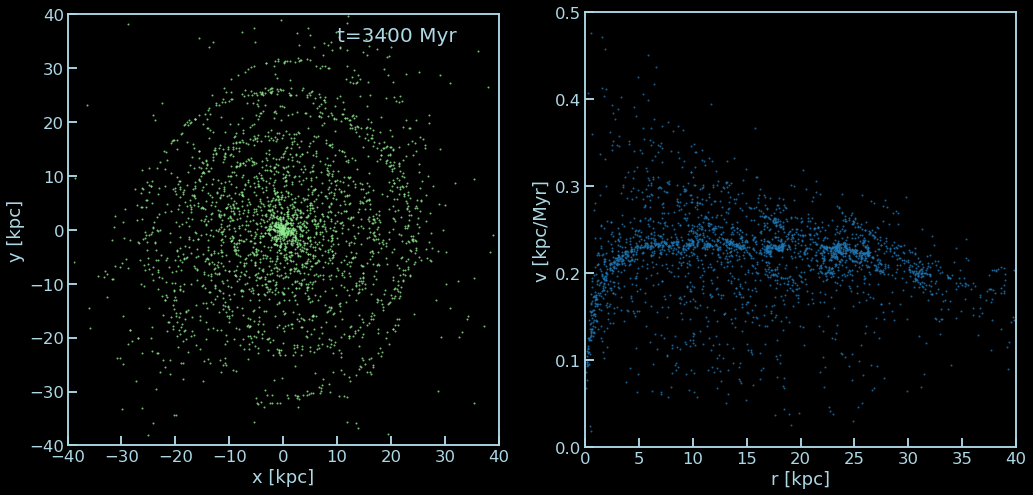

In [40]:
save_animation(data3,t_list3,'ani/animation04.mp4',distinguish_extra_obj=True,alpha=0.8)